In [1]:
!pip install torchsummary

earlystopping
10에서 25

epoch
150에서 300

스케쥴러 3에서 10으로

weight_decay=0.001 추가

In [2]:
import glob
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.utils.tensorboard import SummaryWriter

import torchvision.models as models

from torchsummary import summary

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import xml.etree.ElementTree as ET

from copy import deepcopy

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
root_dir = '/kaggle/input/stanford-dogs-dataset'
img_dir = '/images/Images/'
annot_dir = '/annotations/Annotation/'

In [5]:
import os

labels_map = {}
for i, item in enumerate(os.listdir(root_dir + img_dir)):
    sub_folder = os.path.join(root_dir + img_dir, item)
    labels_map[sub_folder.split('-', maxsplit=3)[-1]] = i

labels_map_lst = list(labels_map.items())

In [6]:
def img_crop(annot_path, img):
    tree = ET.parse(annot_path)
    obj = tree.find('./object')
    bndbox = obj.find('bndbox')

    # 강아지 종류
    species = obj.find('name').text

    # 이미지에서의 강아지 위치
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    cropped_img = img[ymin:ymax, xmin:xmax]
    
    label = labels_map.get(species)

    return label, cropped_img

In [7]:
class DogsDataset(Dataset):
    def __init__(self, annot_dir, img_dir, transform=None):
        annot_dir = glob.glob(root_dir + annot_dir + '*/*')
        img_dir = glob.glob(root_dir + img_dir + '*/*.jpg')
        self.annot_dir = sorted(annot_dir)
        self.img_dir = sorted(img_dir)
        
        self.transform = transform
        
    def __len__(self):
        return len(self.img_dir)
        
    def __getitem__(self, idx):
        annot_path = self.annot_dir[idx]
        img_path = self.img_dir[idx]
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        label, img = img_crop(annot_path, img)
        if self.transform is not None:
            img = self.transform(image=img)
            img['label'] = label
            return img

        sample = {'image': img, 'label': label}
        return sample
    
    def getlabel(self, idx):
        annot_path = self.annot_dir[idx]
        tree = ET.parse(annot_path)
        obj = tree.find('./object')
        species = obj.find('name').text
        label = labels_map.get(species)
        return label

In [8]:
transformer = A.Compose([
    A.Resize(224, 224), 
    A.Normalize(), 
    ToTensorV2()
])

In [9]:
total_dataset = DogsDataset(annot_dir=annot_dir,
                           img_dir=img_dir,
                           transform=transformer)

In [10]:
total_label = [total_dataset.getlabel(i) for i in tqdm(range(len(total_dataset)))]

trainset_idx, testset_idx = train_test_split(range(len(total_dataset)),
                test_size=0.2, random_state=42, shuffle=True, stratify=total_label)

100%|██████████| 20580/20580 [00:11<00:00, 1722.97it/s]


In [13]:
train_set_ = Subset(total_dataset, trainset_idx)

train_label = [data['label'] for data in train_set_]

trainset_idx, validset_idx = train_test_split(range(len(trainset_idx)),
                test_size=0.2, random_state=42, shuffle=True, stratify=train_label)

In [14]:
train_set = Subset(train_set_, trainset_idx)
test_set = Subset(total_dataset, testset_idx)
valid_set = Subset(train_set_, validset_idx)

# 시각화

  0%|          | 0/16464 [07:44<?, ?it/s]


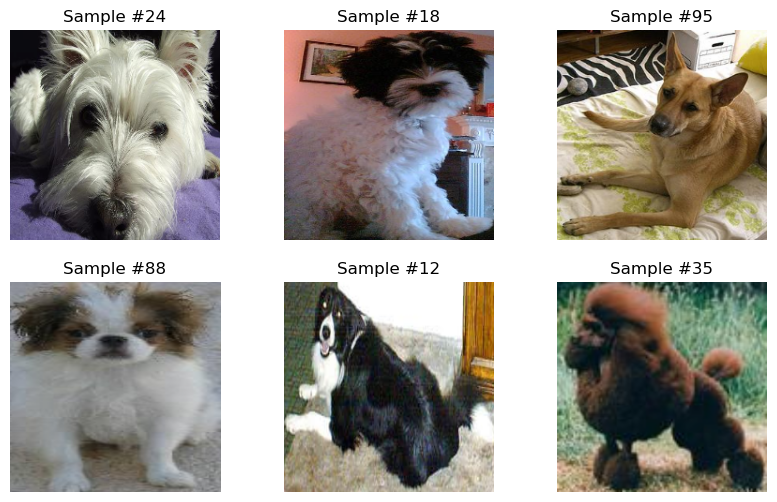

In [15]:
figure, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axes = axes.flatten()

for i in range(6):
    rand_i = np.random.randint(0, len(total_dataset))
    sample = total_dataset[rand_i]
    image = sample['image'].permute(1, 2, 0)
    label = sample['label']
    
    mean=torch.tensor([0.485, 0.456, 0.406]) 
    std=torch.tensor([0.229, 0.224, 0.225])
    image.mul_(std)
    image.add_(mean)
    
    axes[i].axis('off')
    axes[i].imshow(image)
    axes[i].set_title('Sample #{}'.format(label))

# 데이터 적재

In [16]:
batch_size = 32
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validloader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [17]:
train_iter = iter(trainloader)
batch = next(train_iter)
batch['image'].size(), len(batch['label'])

(torch.Size([32, 3, 224, 224]), 32)

# 모델 생성

In [18]:
model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [19]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 모델 변경

In [20]:
model.fc = nn.Linear(in_features=2048, out_features=120, bias=True)

In [21]:
for parameter in model.parameters():
    parameter.requires_grad = False

In [22]:
for parameter in model.fc.parameters():
    parameter.requires_grad=True

In [23]:
for parameter in model.parameters():
    print(parameter.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [24]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
out = model(batch['image'].to(device))
out.shape

torch.Size([32, 120])

In [26]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

In [27]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [28]:
def validate(model, validloader, loss_fn):
    total = 0   
    correct = 0
    valid_loss = 0
    valid_accuracy = 0

  
    with torch.no_grad():
        for batch in validloader:
            images=batch['image'].to(device)
            labels=batch['label']
            labels = torch.Tensor(labels).to(device)

            logit = model(images) 
            _, preds = torch.max(logit, 1)
            correct += int((preds == labels).sum())
            total += labels.shape[0]

            loss = loss_fn(logit, labels)
            valid_loss += loss.item()

        valid_accuracy = correct / total
  
    return valid_loss, valid_accuracy

In [29]:
def train_loop(model, trainloader, loss_fn, epochs, optimizer):
    steps = 0
    steps_per_epoch = len(trainloader)
    min_loss = np.inf
    max_accuracy = -np.inf
    trigger = 0
    p = 25
    save_loss = np.inf

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch in tqdm(trainloader):
            images=batch['image'].to(device)
            labels=batch['label']
            labels = torch.Tensor(labels).to(device)
            
            steps+=1
                      
            predict = model(images)
            loss = loss_fn(predict, labels)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            train_loss += loss.item()

            if (steps % steps_per_epoch) == 0:
                model.eval()
                valid_loss, valid_accuracy = validate(model, validloader, loss_fn)    
                
                print('Epoch : {}/{}.......'.format(epoch+1, epochs),            
                    'Train Loss : {:.3f}'.format(train_loss/len(trainloader)), 
                    'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)), 
                    'Valid Accuracy : {:.3f}'.format(valid_accuracy))

                if (valid_loss < save_loss) and (valid_accuracy >= max_accuracy):
                    save_loss = valid_loss
                    print('save ckpt')
                    min_loss = valid_loss
                    max_accuracy = valid_accuracy

                    best_model = deepcopy(model)
                    torch.save(best_model.state_dict(), 'best_ckpt_transfer_res101_batch32_early25_wd.pth')

                
                # --- early stopping --- #
                if valid_loss > min_loss:
                    print('----trigger----', trigger+1)
                    trigger += 1
                    if trigger > p:
                        print('Early Stopping')
                        print('training loop is finished')
                        return 
                else:
                    trigger = 0
                    min_loss = valid_loss
                    
                scheduler.step(valid_loss)


In [30]:
epochs = 300
%time train_loop(model, trainloader, loss_fn, epochs, optimizer)

100%|█████████▉| 411/412 [01:45<00:00,  4.09it/s]

Epoch : 1/300....... Train Loss : 1.928 Valid Loss : 0.912 Valid Accuracy : 0.815
save ckpt


100%|█████████▉| 411/412 [01:46<00:00,  3.87it/s]

Epoch : 2/300....... Train Loss : 0.649 Valid Loss : 0.685 Valid Accuracy : 0.838
save ckpt


100%|█████████▉| 411/412 [01:47<00:00,  3.79it/s]

Epoch : 3/300....... Train Loss : 0.472 Valid Loss : 0.628 Valid Accuracy : 0.843
save ckpt


100%|█████████▉| 411/412 [01:46<00:00,  3.99it/s]

Epoch : 4/300....... Train Loss : 0.394 Valid Loss : 0.600 Valid Accuracy : 0.843
save ckpt


100%|█████████▉| 411/412 [01:45<00:00,  4.06it/s]

Epoch : 5/300....... Train Loss : 0.347 Valid Loss : 0.573 Valid Accuracy : 0.853
save ckpt


100%|██████████| 412/412 [02:13<00:00,  3.09it/s]


Epoch : 6/300....... Train Loss : 0.310 Valid Loss : 0.570 Valid Accuracy : 0.845


100%|██████████| 412/412 [02:13<00:00,  3.09it/s]


Epoch : 7/300....... Train Loss : 0.288 Valid Loss : 0.571 Valid Accuracy : 0.844
----trigger---- 1


100%|██████████| 412/412 [02:13<00:00,  3.08it/s]


Epoch : 8/300....... Train Loss : 0.277 Valid Loss : 0.553 Valid Accuracy : 0.852


100%|██████████| 412/412 [02:13<00:00,  3.08it/s]


Epoch : 9/300....... Train Loss : 0.264 Valid Loss : 0.572 Valid Accuracy : 0.841
----trigger---- 1


100%|██████████| 412/412 [02:11<00:00,  3.13it/s]


Epoch : 10/300....... Train Loss : 0.262 Valid Loss : 0.569 Valid Accuracy : 0.845
----trigger---- 2


100%|█████████▉| 411/412 [01:47<00:00,  3.81it/s]

Epoch : 11/300....... Train Loss : 0.247 Valid Loss : 0.544 Valid Accuracy : 0.855
save ckpt


100%|██████████| 412/412 [02:11<00:00,  3.13it/s]


Epoch : 12/300....... Train Loss : 0.240 Valid Loss : 0.540 Valid Accuracy : 0.849


100%|██████████| 412/412 [02:10<00:00,  3.17it/s]


Epoch : 13/300....... Train Loss : 0.242 Valid Loss : 0.562 Valid Accuracy : 0.842
----trigger---- 1


100%|██████████| 412/412 [02:12<00:00,  3.12it/s]


Epoch : 14/300....... Train Loss : 0.237 Valid Loss : 0.545 Valid Accuracy : 0.846
----trigger---- 2


100%|██████████| 412/412 [02:10<00:00,  3.16it/s]


Epoch : 15/300....... Train Loss : 0.230 Valid Loss : 0.540 Valid Accuracy : 0.852
----trigger---- 3


100%|██████████| 412/412 [02:09<00:00,  3.19it/s]


Epoch : 16/300....... Train Loss : 0.234 Valid Loss : 0.556 Valid Accuracy : 0.848
----trigger---- 4


100%|██████████| 412/412 [02:15<00:00,  3.04it/s]


Epoch : 17/300....... Train Loss : 0.234 Valid Loss : 0.553 Valid Accuracy : 0.847
----trigger---- 5


100%|██████████| 412/412 [02:14<00:00,  3.06it/s]


Epoch : 18/300....... Train Loss : 0.224 Valid Loss : 0.553 Valid Accuracy : 0.843
----trigger---- 6


100%|██████████| 412/412 [02:10<00:00,  3.16it/s]


Epoch : 19/300....... Train Loss : 0.231 Valid Loss : 0.544 Valid Accuracy : 0.848
----trigger---- 7


100%|██████████| 412/412 [02:09<00:00,  3.17it/s]


Epoch : 20/300....... Train Loss : 0.228 Valid Loss : 0.537 Valid Accuracy : 0.847


100%|██████████| 412/412 [02:13<00:00,  3.08it/s]


Epoch : 21/300....... Train Loss : 0.229 Valid Loss : 0.521 Valid Accuracy : 0.852


100%|██████████| 412/412 [02:11<00:00,  3.13it/s]


Epoch : 22/300....... Train Loss : 0.224 Valid Loss : 0.517 Valid Accuracy : 0.853


100%|██████████| 412/412 [02:13<00:00,  3.10it/s]


Epoch : 23/300....... Train Loss : 0.222 Valid Loss : 0.551 Valid Accuracy : 0.845
----trigger---- 1


100%|█████████▉| 411/412 [01:44<00:00,  4.09it/s]

Epoch : 24/300....... Train Loss : 0.223 Valid Loss : 0.507 Valid Accuracy : 0.858
save ckpt


100%|██████████| 412/412 [02:10<00:00,  3.16it/s]


Epoch : 25/300....... Train Loss : 0.225 Valid Loss : 0.542 Valid Accuracy : 0.851
----trigger---- 1


100%|██████████| 412/412 [02:09<00:00,  3.17it/s]


Epoch : 26/300....... Train Loss : 0.224 Valid Loss : 0.530 Valid Accuracy : 0.848
----trigger---- 2


100%|██████████| 412/412 [02:11<00:00,  3.14it/s]


Epoch : 27/300....... Train Loss : 0.220 Valid Loss : 0.519 Valid Accuracy : 0.851
----trigger---- 3


100%|██████████| 412/412 [02:10<00:00,  3.17it/s]


Epoch : 28/300....... Train Loss : 0.221 Valid Loss : 0.547 Valid Accuracy : 0.845
----trigger---- 4


100%|██████████| 412/412 [02:08<00:00,  3.20it/s]


Epoch : 29/300....... Train Loss : 0.221 Valid Loss : 0.507 Valid Accuracy : 0.854


100%|██████████| 412/412 [02:08<00:00,  3.19it/s]


Epoch : 30/300....... Train Loss : 0.222 Valid Loss : 0.526 Valid Accuracy : 0.851
----trigger---- 1


100%|██████████| 412/412 [02:09<00:00,  3.17it/s]


Epoch : 31/300....... Train Loss : 0.221 Valid Loss : 0.525 Valid Accuracy : 0.847
----trigger---- 2


100%|██████████| 412/412 [02:10<00:00,  3.16it/s]


Epoch : 32/300....... Train Loss : 0.224 Valid Loss : 0.541 Valid Accuracy : 0.844
----trigger---- 3


100%|██████████| 412/412 [02:12<00:00,  3.12it/s]


Epoch : 33/300....... Train Loss : 0.219 Valid Loss : 0.559 Valid Accuracy : 0.835
----trigger---- 4


100%|██████████| 412/412 [02:11<00:00,  3.14it/s]


Epoch : 34/300....... Train Loss : 0.224 Valid Loss : 0.534 Valid Accuracy : 0.844
----trigger---- 5


100%|██████████| 412/412 [02:10<00:00,  3.15it/s]


Epoch : 35/300....... Train Loss : 0.216 Valid Loss : 0.514 Valid Accuracy : 0.855
----trigger---- 6


100%|██████████| 412/412 [02:11<00:00,  3.13it/s]


Epoch : 36/300....... Train Loss : 0.223 Valid Loss : 0.527 Valid Accuracy : 0.851
----trigger---- 7


100%|██████████| 412/412 [02:11<00:00,  3.13it/s]


Epoch : 37/300....... Train Loss : 0.222 Valid Loss : 0.542 Valid Accuracy : 0.842
----trigger---- 8


100%|██████████| 412/412 [02:10<00:00,  3.15it/s]


Epoch : 38/300....... Train Loss : 0.222 Valid Loss : 0.515 Valid Accuracy : 0.848
----trigger---- 9


100%|██████████| 412/412 [02:11<00:00,  3.14it/s]


Epoch : 39/300....... Train Loss : 0.215 Valid Loss : 0.535 Valid Accuracy : 0.852
----trigger---- 10


100%|██████████| 412/412 [02:10<00:00,  3.16it/s]


Epoch : 40/300....... Train Loss : 0.219 Valid Loss : 0.534 Valid Accuracy : 0.847
----trigger---- 11
Epoch 00040: reducing learning rate of group 0 to 5.0000e-04.


100%|██████████| 412/412 [02:10<00:00,  3.15it/s]


Epoch : 41/300....... Train Loss : 0.182 Valid Loss : 0.513 Valid Accuracy : 0.853
----trigger---- 12


100%|██████████| 412/412 [02:12<00:00,  3.12it/s]


Epoch : 42/300....... Train Loss : 0.184 Valid Loss : 0.512 Valid Accuracy : 0.851
----trigger---- 13


100%|██████████| 412/412 [02:11<00:00,  3.14it/s]


Epoch : 43/300....... Train Loss : 0.187 Valid Loss : 0.493 Valid Accuracy : 0.856


100%|██████████| 412/412 [02:11<00:00,  3.14it/s]


Epoch : 44/300....... Train Loss : 0.185 Valid Loss : 0.506 Valid Accuracy : 0.857
----trigger---- 1


100%|██████████| 412/412 [02:09<00:00,  3.18it/s]


Epoch : 45/300....... Train Loss : 0.185 Valid Loss : 0.501 Valid Accuracy : 0.855
----trigger---- 2


100%|██████████| 412/412 [02:10<00:00,  3.15it/s]


Epoch : 46/300....... Train Loss : 0.188 Valid Loss : 0.507 Valid Accuracy : 0.853
----trigger---- 3


100%|██████████| 412/412 [02:09<00:00,  3.17it/s]


Epoch : 47/300....... Train Loss : 0.191 Valid Loss : 0.492 Valid Accuracy : 0.856


100%|██████████| 412/412 [02:09<00:00,  3.17it/s]


Epoch : 48/300....... Train Loss : 0.190 Valid Loss : 0.512 Valid Accuracy : 0.860
----trigger---- 1


100%|█████████▉| 411/412 [01:46<00:00,  3.98it/s]

Epoch : 49/300....... Train Loss : 0.192 Valid Loss : 0.503 Valid Accuracy : 0.858
save ckpt


100%|██████████| 412/412 [02:09<00:00,  3.17it/s]


Epoch : 50/300....... Train Loss : 0.196 Valid Loss : 0.504 Valid Accuracy : 0.859
----trigger---- 1


100%|██████████| 412/412 [02:08<00:00,  3.21it/s]


Epoch : 51/300....... Train Loss : 0.190 Valid Loss : 0.527 Valid Accuracy : 0.848
----trigger---- 2


100%|██████████| 412/412 [02:08<00:00,  3.22it/s]


Epoch : 52/300....... Train Loss : 0.192 Valid Loss : 0.506 Valid Accuracy : 0.855
----trigger---- 3


100%|██████████| 412/412 [02:09<00:00,  3.19it/s]


Epoch : 53/300....... Train Loss : 0.193 Valid Loss : 0.510 Valid Accuracy : 0.853
----trigger---- 4


100%|█████████▉| 411/412 [01:42<00:00,  4.14it/s]

Epoch : 54/300....... Train Loss : 0.194 Valid Loss : 0.492 Valid Accuracy : 0.859
save ckpt


100%|██████████| 412/412 [02:12<00:00,  3.11it/s]


Epoch : 55/300....... Train Loss : 0.191 Valid Loss : 0.514 Valid Accuracy : 0.853
----trigger---- 1


100%|██████████| 412/412 [02:11<00:00,  3.14it/s]


Epoch : 56/300....... Train Loss : 0.193 Valid Loss : 0.495 Valid Accuracy : 0.857
----trigger---- 2


100%|█████████▉| 411/412 [01:51<00:00,  3.94it/s]

Epoch : 57/300....... Train Loss : 0.193 Valid Loss : 0.481 Valid Accuracy : 0.860
save ckpt


100%|██████████| 412/412 [02:08<00:00,  3.21it/s]


Epoch : 58/300....... Train Loss : 0.197 Valid Loss : 0.487 Valid Accuracy : 0.865
----trigger---- 1


100%|██████████| 412/412 [02:09<00:00,  3.18it/s]


Epoch : 59/300....... Train Loss : 0.192 Valid Loss : 0.523 Valid Accuracy : 0.852
----trigger---- 2


100%|██████████| 412/412 [02:08<00:00,  3.20it/s]


Epoch : 60/300....... Train Loss : 0.193 Valid Loss : 0.490 Valid Accuracy : 0.859
----trigger---- 3


100%|██████████| 412/412 [02:08<00:00,  3.20it/s]


Epoch : 61/300....... Train Loss : 0.195 Valid Loss : 0.498 Valid Accuracy : 0.857
----trigger---- 4


100%|██████████| 412/412 [02:11<00:00,  3.14it/s]


Epoch : 62/300....... Train Loss : 0.194 Valid Loss : 0.514 Valid Accuracy : 0.852
----trigger---- 5


100%|██████████| 412/412 [02:08<00:00,  3.21it/s]


Epoch : 63/300....... Train Loss : 0.193 Valid Loss : 0.509 Valid Accuracy : 0.855
----trigger---- 6


100%|██████████| 412/412 [02:12<00:00,  3.11it/s]


Epoch : 64/300....... Train Loss : 0.192 Valid Loss : 0.492 Valid Accuracy : 0.860
----trigger---- 7


100%|██████████| 412/412 [02:13<00:00,  3.08it/s]


Epoch : 65/300....... Train Loss : 0.195 Valid Loss : 0.503 Valid Accuracy : 0.855
----trigger---- 8


100%|██████████| 412/412 [02:11<00:00,  3.14it/s]


Epoch : 66/300....... Train Loss : 0.193 Valid Loss : 0.515 Valid Accuracy : 0.855
----trigger---- 9


100%|██████████| 412/412 [02:18<00:00,  2.98it/s]


Epoch : 67/300....... Train Loss : 0.194 Valid Loss : 0.487 Valid Accuracy : 0.861
----trigger---- 10


100%|██████████| 412/412 [02:11<00:00,  3.14it/s]


Epoch : 68/300....... Train Loss : 0.194 Valid Loss : 0.496 Valid Accuracy : 0.856
----trigger---- 11
Epoch 00068: reducing learning rate of group 0 to 2.5000e-04.


100%|██████████| 412/412 [02:11<00:00,  3.14it/s]


Epoch : 69/300....... Train Loss : 0.174 Valid Loss : 0.506 Valid Accuracy : 0.861
----trigger---- 12


100%|██████████| 412/412 [02:10<00:00,  3.16it/s]


Epoch : 70/300....... Train Loss : 0.174 Valid Loss : 0.488 Valid Accuracy : 0.863
----trigger---- 13


100%|██████████| 412/412 [02:09<00:00,  3.18it/s]


Epoch : 71/300....... Train Loss : 0.179 Valid Loss : 0.519 Valid Accuracy : 0.856
----trigger---- 14


100%|██████████| 412/412 [02:09<00:00,  3.19it/s]


Epoch : 72/300....... Train Loss : 0.176 Valid Loss : 0.503 Valid Accuracy : 0.854
----trigger---- 15


100%|██████████| 412/412 [02:09<00:00,  3.19it/s]


Epoch : 73/300....... Train Loss : 0.173 Valid Loss : 0.499 Valid Accuracy : 0.862
----trigger---- 16


100%|██████████| 412/412 [02:09<00:00,  3.18it/s]


Epoch : 74/300....... Train Loss : 0.179 Valid Loss : 0.496 Valid Accuracy : 0.858
----trigger---- 17


100%|██████████| 412/412 [02:10<00:00,  3.16it/s]


Epoch : 75/300....... Train Loss : 0.177 Valid Loss : 0.485 Valid Accuracy : 0.861
----trigger---- 18


100%|██████████| 412/412 [02:10<00:00,  3.17it/s]


Epoch : 76/300....... Train Loss : 0.180 Valid Loss : 0.497 Valid Accuracy : 0.859
----trigger---- 19


100%|██████████| 412/412 [02:11<00:00,  3.14it/s]


Epoch : 77/300....... Train Loss : 0.180 Valid Loss : 0.511 Valid Accuracy : 0.852
----trigger---- 20


100%|██████████| 412/412 [02:13<00:00,  3.09it/s]


Epoch : 78/300....... Train Loss : 0.176 Valid Loss : 0.505 Valid Accuracy : 0.855
----trigger---- 21


100%|██████████| 412/412 [02:15<00:00,  3.03it/s]


Epoch : 79/300....... Train Loss : 0.182 Valid Loss : 0.490 Valid Accuracy : 0.861
----trigger---- 22
Epoch 00079: reducing learning rate of group 0 to 1.2500e-04.


100%|█████████▉| 411/412 [02:02<00:00,  3.56it/s]

Epoch : 80/300....... Train Loss : 0.168 Valid Loss : 0.477 Valid Accuracy : 0.862
save ckpt


100%|██████████| 412/412 [02:18<00:00,  2.98it/s]


Epoch : 81/300....... Train Loss : 0.172 Valid Loss : 0.477 Valid Accuracy : 0.861
----trigger---- 1


100%|██████████| 412/412 [02:12<00:00,  3.11it/s]


Epoch : 82/300....... Train Loss : 0.167 Valid Loss : 0.499 Valid Accuracy : 0.858
----trigger---- 2


100%|██████████| 412/412 [02:12<00:00,  3.11it/s]


Epoch : 83/300....... Train Loss : 0.169 Valid Loss : 0.510 Valid Accuracy : 0.855
----trigger---- 3


100%|██████████| 412/412 [02:11<00:00,  3.12it/s]


Epoch : 84/300....... Train Loss : 0.170 Valid Loss : 0.485 Valid Accuracy : 0.862
----trigger---- 4


100%|██████████| 412/412 [02:11<00:00,  3.13it/s]


Epoch : 85/300....... Train Loss : 0.173 Valid Loss : 0.489 Valid Accuracy : 0.860
----trigger---- 5


100%|██████████| 412/412 [02:11<00:00,  3.13it/s]


Epoch : 86/300....... Train Loss : 0.173 Valid Loss : 0.502 Valid Accuracy : 0.858
----trigger---- 6


100%|██████████| 412/412 [02:16<00:00,  3.02it/s]


Epoch : 87/300....... Train Loss : 0.171 Valid Loss : 0.483 Valid Accuracy : 0.866
----trigger---- 7


100%|██████████| 412/412 [02:12<00:00,  3.11it/s]


Epoch : 88/300....... Train Loss : 0.167 Valid Loss : 0.512 Valid Accuracy : 0.854
----trigger---- 8


100%|██████████| 412/412 [02:10<00:00,  3.15it/s]


Epoch : 89/300....... Train Loss : 0.172 Valid Loss : 0.507 Valid Accuracy : 0.858
----trigger---- 9


100%|██████████| 412/412 [02:10<00:00,  3.15it/s]


Epoch : 90/300....... Train Loss : 0.174 Valid Loss : 0.496 Valid Accuracy : 0.862
----trigger---- 10


100%|██████████| 412/412 [02:09<00:00,  3.17it/s]


Epoch : 91/300....... Train Loss : 0.172 Valid Loss : 0.491 Valid Accuracy : 0.861
----trigger---- 11
Epoch 00091: reducing learning rate of group 0 to 6.2500e-05.


100%|██████████| 412/412 [02:11<00:00,  3.13it/s]


Epoch : 92/300....... Train Loss : 0.169 Valid Loss : 0.510 Valid Accuracy : 0.853
----trigger---- 12


100%|██████████| 412/412 [02:10<00:00,  3.16it/s]


Epoch : 93/300....... Train Loss : 0.168 Valid Loss : 0.497 Valid Accuracy : 0.862
----trigger---- 13


100%|██████████| 412/412 [02:12<00:00,  3.12it/s]


Epoch : 94/300....... Train Loss : 0.170 Valid Loss : 0.479 Valid Accuracy : 0.866
----trigger---- 14


100%|██████████| 412/412 [02:11<00:00,  3.14it/s]


Epoch : 95/300....... Train Loss : 0.169 Valid Loss : 0.478 Valid Accuracy : 0.862
----trigger---- 15


100%|█████████▉| 411/412 [01:44<00:00,  3.97it/s]

Epoch : 96/300....... Train Loss : 0.168 Valid Loss : 0.473 Valid Accuracy : 0.868
save ckpt


100%|██████████| 412/412 [02:09<00:00,  3.18it/s]


Epoch : 97/300....... Train Loss : 0.169 Valid Loss : 0.484 Valid Accuracy : 0.864
----trigger---- 1


100%|██████████| 412/412 [02:11<00:00,  3.14it/s]


Epoch : 98/300....... Train Loss : 0.167 Valid Loss : 0.496 Valid Accuracy : 0.858
----trigger---- 2


100%|██████████| 412/412 [02:09<00:00,  3.19it/s]


Epoch : 99/300....... Train Loss : 0.170 Valid Loss : 0.487 Valid Accuracy : 0.862
----trigger---- 3


100%|██████████| 412/412 [02:10<00:00,  3.16it/s]


Epoch : 100/300....... Train Loss : 0.169 Valid Loss : 0.480 Valid Accuracy : 0.864
----trigger---- 4


100%|██████████| 412/412 [02:08<00:00,  3.21it/s]


Epoch : 101/300....... Train Loss : 0.167 Valid Loss : 0.496 Valid Accuracy : 0.859
----trigger---- 5


100%|██████████| 412/412 [02:08<00:00,  3.21it/s]


Epoch : 102/300....... Train Loss : 0.170 Valid Loss : 0.488 Valid Accuracy : 0.862
----trigger---- 6


100%|██████████| 412/412 [02:08<00:00,  3.22it/s]


Epoch : 103/300....... Train Loss : 0.172 Valid Loss : 0.491 Valid Accuracy : 0.860
----trigger---- 7


100%|██████████| 412/412 [02:10<00:00,  3.16it/s]


Epoch : 104/300....... Train Loss : 0.165 Valid Loss : 0.498 Valid Accuracy : 0.859
----trigger---- 8


100%|██████████| 412/412 [02:10<00:00,  3.16it/s]


Epoch : 105/300....... Train Loss : 0.171 Valid Loss : 0.500 Valid Accuracy : 0.858
----trigger---- 9


100%|██████████| 412/412 [02:08<00:00,  3.20it/s]


Epoch : 106/300....... Train Loss : 0.167 Valid Loss : 0.483 Valid Accuracy : 0.864
----trigger---- 10


100%|██████████| 412/412 [02:13<00:00,  3.08it/s]


Epoch : 107/300....... Train Loss : 0.169 Valid Loss : 0.482 Valid Accuracy : 0.866
----trigger---- 11
Epoch 00107: reducing learning rate of group 0 to 3.1250e-05.


100%|██████████| 412/412 [02:09<00:00,  3.19it/s]


Epoch : 108/300....... Train Loss : 0.171 Valid Loss : 0.484 Valid Accuracy : 0.862
----trigger---- 12


100%|██████████| 412/412 [02:08<00:00,  3.20it/s]


Epoch : 109/300....... Train Loss : 0.170 Valid Loss : 0.519 Valid Accuracy : 0.853
----trigger---- 13


100%|██████████| 412/412 [02:18<00:00,  2.97it/s]


Epoch : 110/300....... Train Loss : 0.165 Valid Loss : 0.489 Valid Accuracy : 0.860
----trigger---- 14


100%|██████████| 412/412 [02:11<00:00,  3.14it/s]


Epoch : 111/300....... Train Loss : 0.167 Valid Loss : 0.493 Valid Accuracy : 0.861
----trigger---- 15


100%|██████████| 412/412 [02:12<00:00,  3.10it/s]


Epoch : 112/300....... Train Loss : 0.165 Valid Loss : 0.471 Valid Accuracy : 0.866


100%|██████████| 412/412 [02:11<00:00,  3.13it/s]


Epoch : 113/300....... Train Loss : 0.167 Valid Loss : 0.483 Valid Accuracy : 0.863
----trigger---- 1


100%|██████████| 412/412 [02:12<00:00,  3.11it/s]


Epoch : 114/300....... Train Loss : 0.173 Valid Loss : 0.477 Valid Accuracy : 0.867
----trigger---- 2


100%|██████████| 412/412 [02:11<00:00,  3.12it/s]


Epoch : 115/300....... Train Loss : 0.168 Valid Loss : 0.491 Valid Accuracy : 0.860
----trigger---- 3


100%|██████████| 412/412 [02:09<00:00,  3.18it/s]


Epoch : 116/300....... Train Loss : 0.168 Valid Loss : 0.495 Valid Accuracy : 0.865
----trigger---- 4


100%|██████████| 412/412 [02:09<00:00,  3.19it/s]


Epoch : 117/300....... Train Loss : 0.167 Valid Loss : 0.500 Valid Accuracy : 0.860
----trigger---- 5


100%|██████████| 412/412 [02:09<00:00,  3.17it/s]


Epoch : 118/300....... Train Loss : 0.166 Valid Loss : 0.518 Valid Accuracy : 0.855
----trigger---- 6


100%|██████████| 412/412 [02:08<00:00,  3.20it/s]


Epoch : 119/300....... Train Loss : 0.168 Valid Loss : 0.486 Valid Accuracy : 0.862
----trigger---- 7


100%|██████████| 412/412 [02:10<00:00,  3.15it/s]


Epoch : 120/300....... Train Loss : 0.166 Valid Loss : 0.484 Valid Accuracy : 0.862
----trigger---- 8


100%|██████████| 412/412 [02:08<00:00,  3.21it/s]


Epoch : 121/300....... Train Loss : 0.167 Valid Loss : 0.493 Valid Accuracy : 0.860
----trigger---- 9


100%|██████████| 412/412 [02:11<00:00,  3.14it/s]


Epoch : 122/300....... Train Loss : 0.170 Valid Loss : 0.500 Valid Accuracy : 0.860
----trigger---- 10


100%|██████████| 412/412 [02:12<00:00,  3.12it/s]


Epoch : 123/300....... Train Loss : 0.170 Valid Loss : 0.489 Valid Accuracy : 0.862
----trigger---- 11
Epoch 00123: reducing learning rate of group 0 to 1.5625e-05.


100%|██████████| 412/412 [02:12<00:00,  3.10it/s]


Epoch : 124/300....... Train Loss : 0.164 Valid Loss : 0.483 Valid Accuracy : 0.862
----trigger---- 12


100%|██████████| 412/412 [02:10<00:00,  3.15it/s]


Epoch : 125/300....... Train Loss : 0.167 Valid Loss : 0.496 Valid Accuracy : 0.862
----trigger---- 13


100%|██████████| 412/412 [02:10<00:00,  3.15it/s]


Epoch : 126/300....... Train Loss : 0.168 Valid Loss : 0.478 Valid Accuracy : 0.865
----trigger---- 14


100%|██████████| 412/412 [02:11<00:00,  3.13it/s]


Epoch : 127/300....... Train Loss : 0.169 Valid Loss : 0.494 Valid Accuracy : 0.859
----trigger---- 15


100%|██████████| 412/412 [02:09<00:00,  3.19it/s]


Epoch : 128/300....... Train Loss : 0.165 Valid Loss : 0.490 Valid Accuracy : 0.859
----trigger---- 16


100%|██████████| 412/412 [02:09<00:00,  3.19it/s]


Epoch : 129/300....... Train Loss : 0.168 Valid Loss : 0.501 Valid Accuracy : 0.858
----trigger---- 17


100%|██████████| 412/412 [02:09<00:00,  3.17it/s]


Epoch : 130/300....... Train Loss : 0.168 Valid Loss : 0.485 Valid Accuracy : 0.862
----trigger---- 18


100%|██████████| 412/412 [02:09<00:00,  3.18it/s]


Epoch : 131/300....... Train Loss : 0.171 Valid Loss : 0.494 Valid Accuracy : 0.860
----trigger---- 19


100%|██████████| 412/412 [02:10<00:00,  3.15it/s]


Epoch : 132/300....... Train Loss : 0.172 Valid Loss : 0.504 Valid Accuracy : 0.858
----trigger---- 20


100%|██████████| 412/412 [02:11<00:00,  3.12it/s]


Epoch : 133/300....... Train Loss : 0.166 Valid Loss : 0.484 Valid Accuracy : 0.862
----trigger---- 21


100%|██████████| 412/412 [02:11<00:00,  3.13it/s]


Epoch : 134/300....... Train Loss : 0.169 Valid Loss : 0.482 Valid Accuracy : 0.861
----trigger---- 22
Epoch 00134: reducing learning rate of group 0 to 7.8125e-06.


100%|██████████| 412/412 [02:09<00:00,  3.17it/s]


Epoch : 135/300....... Train Loss : 0.162 Valid Loss : 0.474 Valid Accuracy : 0.864
----trigger---- 23


100%|██████████| 412/412 [02:09<00:00,  3.18it/s]


Epoch : 136/300....... Train Loss : 0.168 Valid Loss : 0.494 Valid Accuracy : 0.862
----trigger---- 24


100%|██████████| 412/412 [02:09<00:00,  3.17it/s]


Epoch : 137/300....... Train Loss : 0.167 Valid Loss : 0.491 Valid Accuracy : 0.861
----trigger---- 25


100%|█████████▉| 411/412 [02:09<00:00,  3.17it/s]

Epoch : 138/300....... Train Loss : 0.167 Valid Loss : 0.484 Valid Accuracy : 0.859
----trigger---- 26
Early Stopping
training loop is finished
CPU times: user 4h 39min 23s, sys: 30min 29s, total: 5h 9min 52s
Wall time: 5h 2min 5s


# 모델 예측

In [31]:
test_iter = iter(testloader)

batch = next(test_iter)

images, labels = batch['image'].to(device), batch['label'].to(device)
print(images.size(), labels.size())

rnd_idx = 3
print(images[rnd_idx].shape, labels[rnd_idx])

torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([3, 224, 224]) tensor(47, device='cuda:0')


In [32]:
model.eval()
with torch.no_grad():
    logit = model(images[rnd_idx].unsqueeze(0))
pred = logit.max(dim=1)[1]
print(pred == labels[rnd_idx])

tensor([True], device='cuda:0')


pred: tensor([47], device='cuda:0') labels: tensor(47, device='cuda:0')
torch.Size([224, 224, 3])


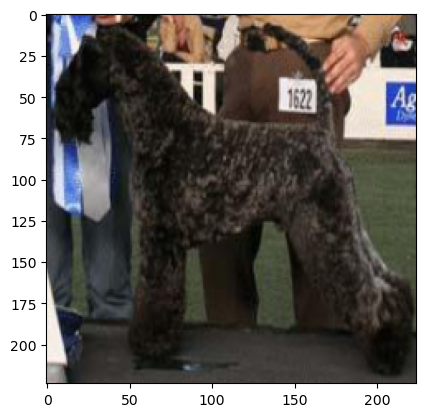

In [33]:
print("pred:", pred, "labels:", labels[rnd_idx])

images = images[rnd_idx].permute(1, 2, 0).cpu()
mean=torch.tensor([0.485, 0.456, 0.406]) 
std=torch.tensor([0.229, 0.224, 0.225])
images.mul_(std)
images.add_(mean)
print(images.shape)
plt.imshow(images)

In [34]:
def evaluation(model, testloader, loss_fn):
    total = 0   
    correct = 0
    test_loss = 0
    test_accuracy = 0

    with torch.no_grad():
        for batch in tqdm(testloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)

            logit = model(images)
            _, preds = torch.max(logit, 1)

            correct += int((preds == labels).sum())
            total += labels.shape[0]

            loss = loss_fn(logit, labels)
            test_loss += loss.item()
            
        test_accuracy = correct / total
   
        print('Test Loss : {:.3f}'.format(test_loss/len(testloader)), 
            'Test Accuracy : {:.3f}'.format(test_accuracy))

model.eval()
evaluation(model, testloader, loss_fn)  

100%|██████████| 129/129 [00:52<00:00,  2.48it/s]

Test Loss : 0.483 Test Accuracy : 0.862


# 모델 저장

In [35]:
torch.save(model.state_dict(), 'last_ckpt_transfer_res101_batch32_early25_wd.pth')

In [36]:
last_state_dict = torch.load('last_ckpt_transfer_res101_batch32_early25_wd.pth')

In [37]:
last_model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
last_model.fc = nn.Linear(in_features=2048, out_features=120)
last_model.to(device)
last_model.get_parameter = last_model.load_state_dict(last_state_dict)

In [38]:
last_model.eval()
evaluation(last_model, testloader, loss_fn)  

100%|██████████| 129/129 [00:31<00:00,  4.05it/s]

Test Loss : 0.483 Test Accuracy : 0.862


In [39]:
best_state_dict = torch.load('best_ckpt_transfer_res101_batch32_early25_wd.pth')

In [40]:
best_model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
best_model.fc = nn.Linear(in_features=2048, out_features=120)
best_model.to(device)
best_model.get_parameter = best_model.load_state_dict(best_state_dict)

In [41]:
best_model.eval()
evaluation(best_model, testloader, loss_fn)

100%|██████████| 129/129 [00:32<00:00,  4.01it/s]

Test Loss : 0.477 Test Accuracy : 0.865
